In [1]:
!git clone https://github.com/marijal74/ml_pix2pix.git

Cloning into 'ml_pix2pix'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 164 (delta 93), reused 146 (delta 81), pack-reused 0
Receiving objects: 100% (164/164), 1.60 MiB | 5.07 MiB/s, done.
Resolving deltas: 100% (93/93), done.


In [26]:
!rm -r ml_pix2pix/

In [2]:
from ml_pix2pix.src.discriminator import Discriminator
from ml_pix2pix.src.generator import UNet
from ml_pix2pix.src import utils
from ml_pix2pix.src import losses
from ml_pix2pix.src.process_data import ImageDataset, Pix2PixDataset
from ml_pix2pix.src import process_data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import time
import multiprocessing

# Loading the Dataset

Using a custom class for loading a dataset using an enum.

In [3]:
pix2pix_dataset = Pix2PixDataset.FACADES
print("Which dataset:" + pix2pix_dataset.value)
print("Dataset url:" + pix2pix_dataset.get_url())
print("Batch size: {}, epochs: {}".format(pix2pix_dataset.batch_size(), pix2pix_dataset.num_epochs()))

Which dataset:facades
Dataset url:http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Pix2PixDataset.FACADES
Batch size: 1, epochs: 200


In [4]:
batch_size = pix2pix_dataset.batch_size()
epochs = pix2pix_dataset.num_epochs()

Pix2PixDataset.FACADES


Downloading the dataseet into `data` folder with `train`, `val` and `test` subfolders. All images are paired. `ImageDataset` class subclasses `pytorch.Dataset` class. When fetching a sample from a dataset, a sample is being preprocessed using transformations described in the original paper.

In [5]:
process_data.download_dataset(pix2pix_dataset)

Creating data folder


In [6]:
train_dataset = ImageDataset(pix2pix_dataset)
train_dataset.load_dataset()

In [7]:
print('Images in train dataset: {}'.format(train_dataset.__len__()))

Images in train dataset: 400


In [8]:
num_threads = multiprocessing.cpu_count()
print(f'Number of available threads:{num_threads}')

Number of available threads:2


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True, num_workers=num_threads)

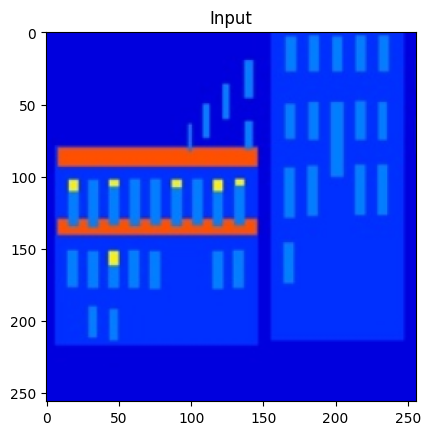

In [10]:
item = train_dataset.__getitem__(0)
plt.imshow(item[0].permute(1, 2, 0))
plt.title('Input')
plt.show()

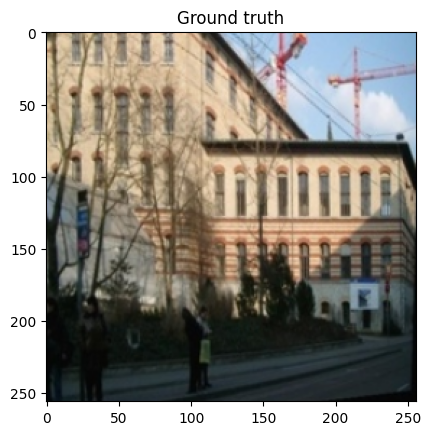

In [11]:
plt.imshow(item[1].permute(1, 2, 0))
plt.title('Ground truth')
plt.show()

# Creating the model

In [12]:
if (torch.cuda.is_available()):
  device = 'cuda'
  print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
  print(f"CUDA version: {torch.version.cuda}")

  # Storing ID of current CUDA device
  cuda_id = torch.cuda.current_device()
  print(f"ID of current CUDA device:{torch.cuda.current_device()}")

  print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
else:
  device = 'cpu'
  print('No cuda available')



Is CUDA supported by this system? True
CUDA version: 12.1
ID of current CUDA device:0
Name of current CUDA device:Tesla T4


In [13]:
print(device)

cuda


In [14]:
generator = UNet()
generator.eval()

UNet(
  (input): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (down4): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))


In [15]:
discriminator = Discriminator(num_channels = 3)
discriminator.eval()

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [16]:
generator.to(device)
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

# Training

In [17]:
inputs, targets = next(iter(train_dataloader))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [18]:
inputs.shape

torch.Size([1, 3, 256, 256])

In [19]:
disc_opt = losses.get_optimizer(discriminator.parameters())
gen_opt = losses.get_optimizer(generator.parameters())

In [20]:
disc_losses = []
gen_losses = []
num_of_steps = len(train_dataloader)

Epoch: 1


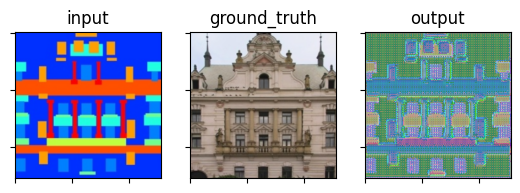

End of epoch 1 Time taken: 25.254078149795532
End of epoch 2 Time taken: 23.263911485671997
End of epoch 3 Time taken: 23.943994283676147
End of epoch 4 Time taken: 23.622825622558594
End of epoch 5 Time taken: 23.4451425075531
End of epoch 6 Time taken: 23.486785650253296
End of epoch 7 Time taken: 23.5558660030365
End of epoch 8 Time taken: 23.573112726211548
End of epoch 9 Time taken: 23.502573490142822
End of epoch 10 Time taken: 23.51422905921936
Epoch: 11


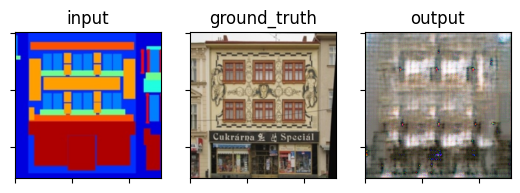

End of epoch 11 Time taken: 23.944602251052856
End of epoch 12 Time taken: 23.542616844177246
End of epoch 13 Time taken: 23.627593755722046
End of epoch 14 Time taken: 23.58337116241455
End of epoch 15 Time taken: 23.55357027053833
End of epoch 16 Time taken: 23.579158067703247
End of epoch 17 Time taken: 23.53352165222168
End of epoch 18 Time taken: 23.58885359764099
End of epoch 19 Time taken: 23.548478603363037
End of epoch 20 Time taken: 23.551459312438965
Epoch: 21


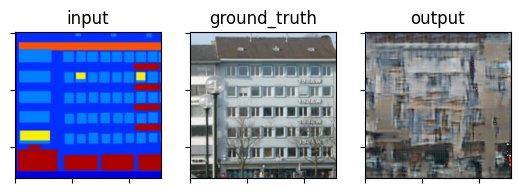

End of epoch 21 Time taken: 23.991541385650635
End of epoch 22 Time taken: 23.5816650390625
End of epoch 23 Time taken: 23.60374927520752
End of epoch 24 Time taken: 23.59195637702942
End of epoch 25 Time taken: 23.561902284622192
End of epoch 26 Time taken: 23.650922775268555
End of epoch 27 Time taken: 23.593694925308228
End of epoch 28 Time taken: 23.733966588974
End of epoch 29 Time taken: 23.766255378723145
End of epoch 30 Time taken: 23.674152135849
Epoch: 31


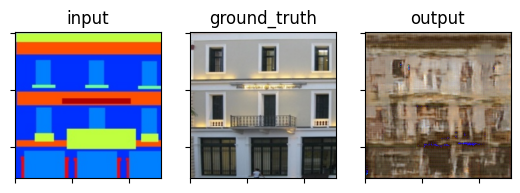

End of epoch 31 Time taken: 24.139654397964478
End of epoch 32 Time taken: 23.59118127822876
End of epoch 33 Time taken: 23.75997233390808
End of epoch 34 Time taken: 23.99958324432373
End of epoch 35 Time taken: 23.573453426361084
End of epoch 36 Time taken: 23.72726082801819
End of epoch 37 Time taken: 23.594215393066406
End of epoch 38 Time taken: 23.601125478744507
End of epoch 39 Time taken: 23.636547327041626
End of epoch 40 Time taken: 23.590283155441284
Epoch: 41


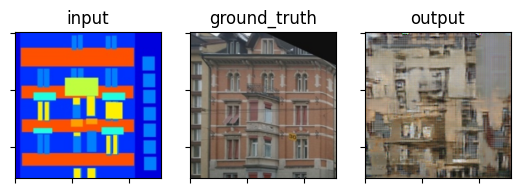

End of epoch 41 Time taken: 24.01023769378662
End of epoch 42 Time taken: 23.713303327560425
End of epoch 43 Time taken: 23.76639461517334
End of epoch 44 Time taken: 23.83897376060486
End of epoch 45 Time taken: 23.915299892425537
End of epoch 46 Time taken: 23.645069122314453
End of epoch 47 Time taken: 23.653448343276978
End of epoch 48 Time taken: 23.705943822860718
End of epoch 49 Time taken: 24.200127124786377
End of epoch 50 Time taken: 23.729015588760376
Epoch: 51


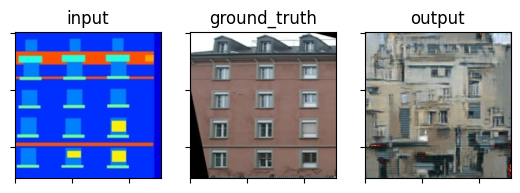

End of epoch 51 Time taken: 24.330286026000977
End of epoch 52 Time taken: 23.87846064567566
End of epoch 53 Time taken: 23.69626522064209
End of epoch 54 Time taken: 23.68434476852417
End of epoch 55 Time taken: 23.627892017364502
End of epoch 56 Time taken: 23.63886070251465
End of epoch 57 Time taken: 23.60679531097412
End of epoch 58 Time taken: 23.59974479675293
End of epoch 59 Time taken: 23.629817724227905
End of epoch 60 Time taken: 23.619019031524658
Epoch: 61


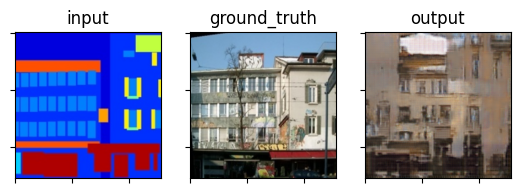

End of epoch 61 Time taken: 23.991522073745728
End of epoch 62 Time taken: 23.838118314743042
End of epoch 63 Time taken: 23.64996027946472
End of epoch 64 Time taken: 24.329339265823364
End of epoch 65 Time taken: 23.607873916625977
End of epoch 66 Time taken: 23.66062045097351
End of epoch 67 Time taken: 23.636162757873535
End of epoch 68 Time taken: 23.713050842285156
End of epoch 69 Time taken: 23.86247229576111
End of epoch 70 Time taken: 23.8692524433136
Epoch: 71


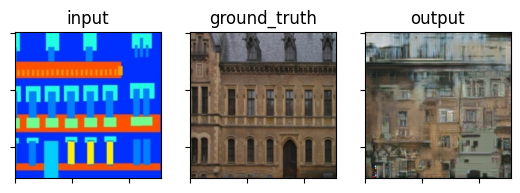

End of epoch 71 Time taken: 24.40307641029358
End of epoch 72 Time taken: 23.832772493362427
End of epoch 73 Time taken: 23.791237354278564
End of epoch 74 Time taken: 23.74252700805664
End of epoch 75 Time taken: 23.671857118606567
End of epoch 76 Time taken: 23.713247537612915
End of epoch 77 Time taken: 23.703232526779175
End of epoch 78 Time taken: 23.7018039226532
End of epoch 79 Time taken: 23.710627555847168
End of epoch 80 Time taken: 23.680127382278442
Epoch: 81


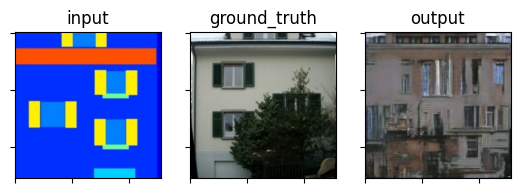

End of epoch 81 Time taken: 24.104148626327515
End of epoch 82 Time taken: 23.695093154907227
End of epoch 83 Time taken: 23.728469610214233
End of epoch 84 Time taken: 23.74321436882019
End of epoch 85 Time taken: 23.727065801620483
End of epoch 86 Time taken: 23.736819982528687
End of epoch 87 Time taken: 23.731846570968628
End of epoch 88 Time taken: 23.752036094665527
End of epoch 89 Time taken: 23.939000368118286
End of epoch 90 Time taken: 23.92441987991333
Epoch: 91


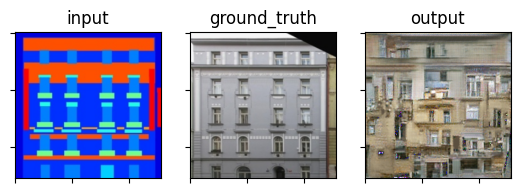

End of epoch 91 Time taken: 24.472947359085083
End of epoch 92 Time taken: 23.99667978286743
End of epoch 93 Time taken: 23.93304419517517
End of epoch 94 Time taken: 23.899959802627563
End of epoch 95 Time taken: 23.766362190246582
End of epoch 96 Time taken: 23.752771139144897
End of epoch 97 Time taken: 23.739115476608276
End of epoch 98 Time taken: 23.712396383285522
End of epoch 99 Time taken: 23.758873224258423
End of epoch 100 Time taken: 23.709167957305908
Epoch: 101


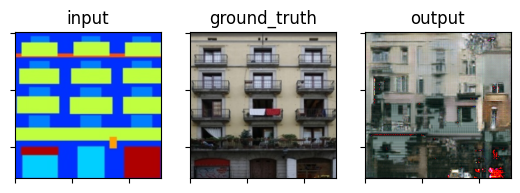

End of epoch 101 Time taken: 24.101589679718018
End of epoch 102 Time taken: 23.756282091140747
End of epoch 103 Time taken: 23.734893560409546
End of epoch 104 Time taken: 23.802194356918335
End of epoch 105 Time taken: 23.780615091323853
End of epoch 106 Time taken: 23.7775559425354
End of epoch 107 Time taken: 23.80480170249939
End of epoch 108 Time taken: 23.738986253738403
End of epoch 109 Time taken: 23.78731417655945
End of epoch 110 Time taken: 23.762800216674805
Epoch: 111


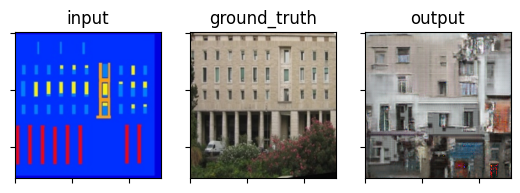

End of epoch 111 Time taken: 24.205589294433594
End of epoch 112 Time taken: 23.90632462501526
End of epoch 113 Time taken: 24.04740262031555
End of epoch 114 Time taken: 24.066328525543213
End of epoch 115 Time taken: 24.02471351623535
End of epoch 116 Time taken: 23.98397469520569
End of epoch 117 Time taken: 23.937236547470093
End of epoch 118 Time taken: 23.840068340301514
End of epoch 119 Time taken: 23.822967052459717
End of epoch 120 Time taken: 23.75758695602417
Epoch: 121


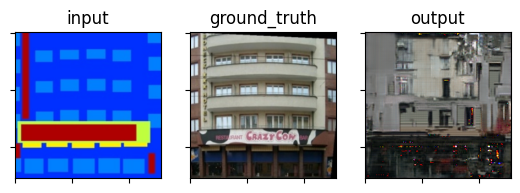

End of epoch 121 Time taken: 24.09443974494934
End of epoch 122 Time taken: 23.80785894393921
End of epoch 123 Time taken: 23.804826259613037
End of epoch 124 Time taken: 23.876600742340088
End of epoch 125 Time taken: 23.833369970321655
End of epoch 126 Time taken: 23.820220947265625
End of epoch 127 Time taken: 23.838040113449097
End of epoch 128 Time taken: 23.81043028831482
End of epoch 129 Time taken: 23.86514163017273
End of epoch 130 Time taken: 23.825903177261353
Epoch: 131


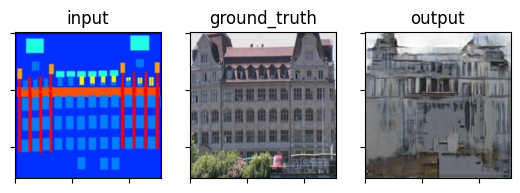

End of epoch 131 Time taken: 24.20106029510498
End of epoch 132 Time taken: 23.84773898124695
End of epoch 133 Time taken: 23.833765268325806
End of epoch 134 Time taken: 23.88099217414856
End of epoch 135 Time taken: 23.938920974731445
End of epoch 136 Time taken: 23.99283456802368
End of epoch 137 Time taken: 24.20943546295166
End of epoch 138 Time taken: 24.12902522087097
End of epoch 139 Time taken: 24.14436388015747
End of epoch 140 Time taken: 24.141470670700073
Epoch: 141


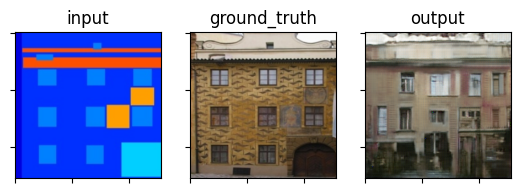

End of epoch 141 Time taken: 24.91823935508728
End of epoch 142 Time taken: 24.210057735443115
End of epoch 143 Time taken: 24.166893482208252
End of epoch 144 Time taken: 24.186713933944702
End of epoch 145 Time taken: 24.141185522079468
End of epoch 146 Time taken: 24.1552996635437
End of epoch 147 Time taken: 24.23018169403076
End of epoch 148 Time taken: 24.198301792144775
End of epoch 149 Time taken: 24.199829816818237
End of epoch 150 Time taken: 24.15567946434021
Epoch: 151


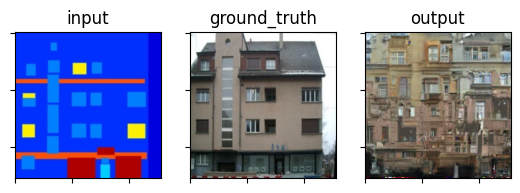

End of epoch 151 Time taken: 24.71392035484314
End of epoch 152 Time taken: 24.206578969955444
End of epoch 153 Time taken: 24.20068621635437
End of epoch 154 Time taken: 24.20278573036194
End of epoch 155 Time taken: 24.172380685806274
End of epoch 156 Time taken: 24.238370418548584
End of epoch 157 Time taken: 24.21922469139099
End of epoch 158 Time taken: 24.15810990333557
End of epoch 159 Time taken: 24.150038480758667
End of epoch 160 Time taken: 23.986205577850342
Epoch: 161


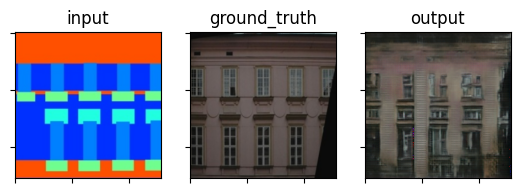

End of epoch 161 Time taken: 24.423489332199097
End of epoch 162 Time taken: 23.981441020965576
End of epoch 163 Time taken: 23.913866758346558
End of epoch 164 Time taken: 23.972142696380615
End of epoch 165 Time taken: 23.92041540145874
End of epoch 166 Time taken: 23.927741527557373
End of epoch 167 Time taken: 23.99101424217224
End of epoch 168 Time taken: 23.940921306610107
End of epoch 169 Time taken: 23.960386276245117
End of epoch 170 Time taken: 23.953083753585815
Epoch: 171


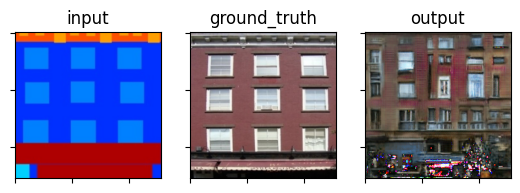

End of epoch 171 Time taken: 24.350430250167847
End of epoch 172 Time taken: 24.008474349975586
End of epoch 173 Time taken: 23.955421686172485
End of epoch 174 Time taken: 23.956687450408936
End of epoch 175 Time taken: 23.91827082633972
End of epoch 176 Time taken: 23.982905626296997
End of epoch 177 Time taken: 23.959398984909058
End of epoch 178 Time taken: 23.931028127670288
End of epoch 179 Time taken: 24.01388454437256
End of epoch 180 Time taken: 23.952085733413696
Epoch: 181


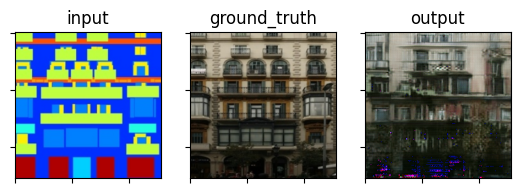

End of epoch 181 Time taken: 24.356009244918823
End of epoch 182 Time taken: 24.38986086845398
End of epoch 183 Time taken: 23.993207931518555
End of epoch 184 Time taken: 24.01555824279785
End of epoch 185 Time taken: 23.966999530792236
End of epoch 186 Time taken: 24.19318962097168
End of epoch 187 Time taken: 24.11808204650879
End of epoch 188 Time taken: 24.23141098022461
End of epoch 189 Time taken: 24.373042106628418
End of epoch 190 Time taken: 24.37947988510132
Epoch: 191


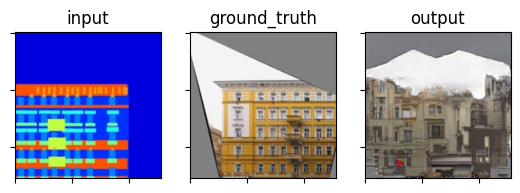

End of epoch 191 Time taken: 24.737146377563477
End of epoch 192 Time taken: 24.30982542037964
End of epoch 193 Time taken: 24.2954843044281
End of epoch 194 Time taken: 24.341949224472046
End of epoch 195 Time taken: 24.36933660507202
End of epoch 196 Time taken: 24.31703233718872
End of epoch 197 Time taken: 24.383612632751465
End of epoch 198 Time taken: 24.674944400787354
End of epoch 199 Time taken: 25.885016918182373
End of epoch 200 Time taken: 27.737799644470215


In [21]:
for epoch in range(epochs):
  start_time = time.time()
  epoch_gen_loss = 0.0
  epoch_disc_loss = 0.0
  for step, (inputs, targets) in enumerate(train_dataloader):
    inputs = inputs.to(device)
    targets = targets.to(device)

    epoch_disc_loss += losses.train_discriminator_step(discriminator, generator, inputs, targets, disc_opt, device)
    gen_loss, generated_image = losses.generator_training_step(discriminator, generator, inputs, targets, gen_opt, device, L1_lambda = 50)
    epoch_gen_loss += gen_loss

    if(epoch % 10 == 0 and step == 0):
      print(f'Epoch: {epoch+1}')
      utils.print_sample(inputs[step], targets[step], generated_image)

  print(f'End of epoch {epoch+1} Time taken: {time.time() - start_time}')
  disc_losses.append(epoch_disc_loss / num_of_steps)
  gen_losses.append(epoch_gen_loss / num_of_steps)


In [23]:
!mkdir saved_models

In [24]:
torch.save(generator.state_dict(), 'saved_models/facades_generator_dict.pth')
torch.save(generator, 'saved_models/facades_generator.pth')
torch.save(discriminator.state_dict(), 'saved_models/facades_discriminator_dict.pth')
torch.save(discriminator, 'saved_models/facades_discriminator.pth')

In [25]:
discriminator_losses = list(map(lambda el: el.item(), disc_losses))
generator_losses = list(map(lambda el: el.item(), gen_losses))

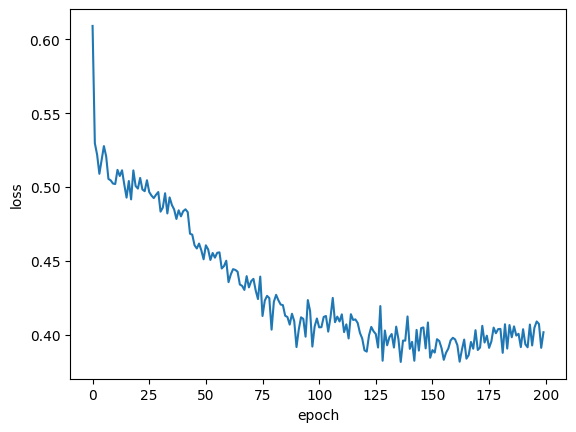

In [26]:
utils.plot_loss(discriminator_losses)

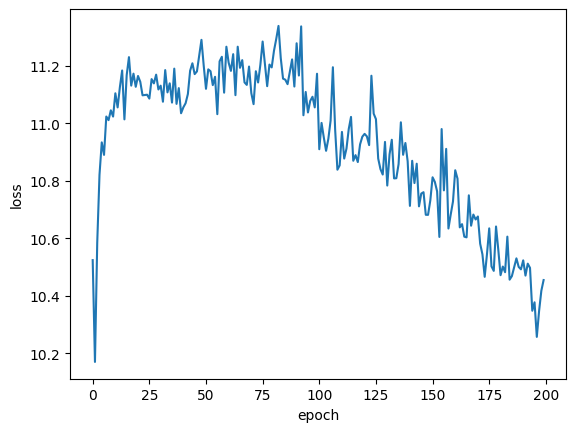

In [27]:
utils.plot_loss(generator_losses)

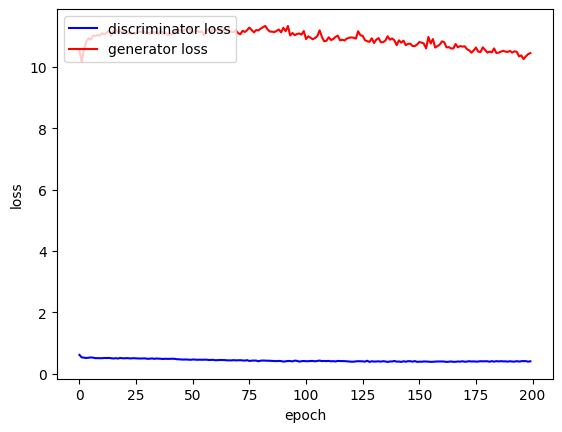

In [28]:
utils.plot_losses(discriminator_losses, generator_losses)

#Testing

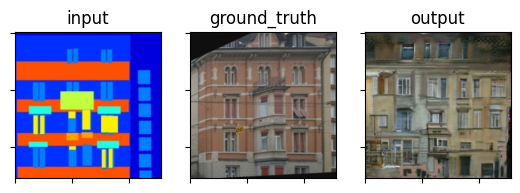

In [50]:
test_dataset = ImageDataset(pix2pix_dataset)
test_dataset.load_dataset()

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True, num_workers=num_threads)

inputs, targets = next(iter(test_dataloader))
gen = generator(inputs.to(device))

utils.print_sample(inputs[0], targets[0], gen)